# Preparación de los datos

El problema que abordaremos es predecir la temperatura máxima para mañana en una ciudad, en este caso Seattle, pero podemos hacerlo por ejemplo de Valencia bajándonos los datos del AEMET (Agencia Estatal de Meteorología) utilizando un año de datos meteorológicos anteriores.

En este caso los datos los he extraído de la herramienta de datos climáticos en línea de NOAA.

Vamos a intentar realizar (a muy bajo nivel) nuestros propios pronósticos (a ver si de Aprendizaje Automático va a salir el nuevo Mario Pinazo o la nueva Mar Gómez).

Lo que necesitamos es un año de temperaturas máximas históricas, las temperaturas de los dos días anteriores y una estimación de un amigo que siempre dice saber todo sobre el tiempo (para ver si sabe tanto o no).

Este es un problema de aprendizaje automático de regresión supervisado. Está supervisado porque tenemos tanto las características (datos de la ciudad) como los objetivos (temperatura) que queremos predecir.

Durante el entrenamiento, le damos al bosque aleatorio (random forest) tanto las características como los objetivos (variable objetivo), y debe aprender a asignar los datos a una predicción.

Además, esta es una tarea de regresión porque el valor objetivo es continuo (a diferencia de las clases discretas en la clasificación).

Dicho esto vamos a ello:

In [ ]:
# Importamos la librería de Pandas
# Importa pandas con alias pd
import pandas as pd

# Leemos el dataset y visualizamos por ejemplo las cinco primeras líneas
# Lee datos desde un archivo CSV con pandas
features = pd.read_csv('temps.csv')
# Muestra las primeras filas del dataframe
features.head(5)

,year,month,day,week,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend
0,2016,1,1,Fri,45,45,45.6,45,43,50,44,29
1,2016,1,2,Sat,44,45,45.7,44,41,50,44,61
2,2016,1,3,Sun,45,44,45.8,41,43,46,47,56
3,2016,1,4,Mon,44,41,45.9,40,44,48,46,53
4,2016,1,5,Tues,41,40,46.0,44,46,46,46,41


In [ ]:
# Muestra resultados por pantalla
print('Las dimensiones de mis datos son:', features.shape)

Las dimensiones de mis datos son: (348, 12)


## One-Hot Encoding

Como tenemos variables categóricas tenemos que pasarlas a One hot encoding :

| week |
|------|
| Mon  |
| Tue  |
| Wed  |
| Thu  |
| Fri  |

Las convertimos en:

| Mon | Tue | Wed | Thu | Fri |
|-----|-----|-----|-----|-----|
| 1   | 0   | 0   | 0   | 0   |
| 0   | 1   | 0   | 0   | 0   |
| 0   | 0   | 1   | 0   | 0   |
| 0   | 0   | 0   | 1   | 0   |
| 0   | 0   | 0   | 0   | 1   |

In [ ]:
# Hacemos one-hot encoding de las variables categóricas
# Codifica variables categóricas (one-hot)
features = pd.get_dummies(features)
# Muestra las primeras filas del dataframe
features.head(5)

,year,month,day,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed
0,2016,1,1,45,45,45.6,45,43,50,44,29,True,False,False,False,False,False,False
1,2016,1,2,44,45,45.7,44,41,50,44,61,False,False,True,False,False,False,False
2,2016,1,3,45,44,45.8,41,43,46,47,56,False,False,False,True,False,False,False
3,2016,1,4,44,41,45.9,40,44,48,46,53,False,True,False,False,False,False,False
4,2016,1,5,41,40,46.0,44,46,46,46,41,False,False,False,False,False,True,False


In [ ]:
# Muestra resultados por pantalla
print('Dimensiones después de realizar el one-hot encoding:', features.shape)

Dimensiones después de realizar el one-hot encoding: (348, 18)


## Features y Labels

In [ ]:
# Usamos numpy para convertir los datos en arrays.
# Importa numpy con alias np
import numpy as np

# Las etiquetas son los valores que queremos predecir
labels = np.array(features['actual'])

# Quitamos las etiquetas de las características de nuestros datos
# El eje 1 se refiere a las columnas
features= features.drop('actual', axis = 1)

# Salvamos/guardamos el nombre de nuestras características para usarlo más tarde
# Línea de código del flujo principal
feature_list = list(features.columns)

# Lo convertimos en numpy array
features = np.array(features)

## Set de training y test

In [ ]:
# Usamos Skicit-learn para dividir en train/test
# Desde sklearn.model_selection importa train_test_split
from sklearn.model_selection import train_test_split

# Creamos 75% para train y 25% para test
# Divide los datos en entrenamiento y prueba
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25,
# Semilla para reproducibilidad
                                                                           random_state = 15)

In [ ]:
# Comprobamos que está todo dividido como toca
# Muestra resultados por pantalla
print('Dimensiones de las características de train:', train_features.shape)
# Muestra resultados por pantalla
print('Dimensiones de las etiquetas de train:', train_labels.shape)
# Muestra resultados por pantalla
print('Dimensiones de las características de test:', test_features.shape)
# Muestra resultados por pantalla
print('Dimensiones de las etiquetas de test:', test_labels.shape)

Dimensiones de las características de train: (261, 17)
Dimensiones de las etiquetas de train: (261,)
Dimensiones de las características de test: (87, 17)
Dimensiones de las etiquetas de test: (87,)


## Como tenemos una serie temporal y ésta tiene una tendencia, establecemos una Baseline

In [ ]:
# El baseline de las predicciones son las establecemos como las medias históricas
baseline_preds = test_features[:, feature_list.index('average')]

# Error del baseline, visualizamos la media del error que cometemos en nuestro baseline
# Línea de código del flujo principal
baseline_errors = abs(baseline_preds - test_labels)
# Muestra resultados por pantalla
print('Error medio de nuestro baseline: ', round(np.mean(baseline_errors), 2), 'grados.')

Error medio de nuestro baseline:  5.06 grados.


## Entrenamos el Random Forest

In [ ]:
# importamos el modelo que vamos a usar
# Desde sklearn.ensemble importa RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

# instanciamos el modelo
# Instancia un Random Forest de regresión con sus hiperparámetros
rf = RandomForestRegressor(n_estimators= 1000, random_state=25)

# Entrenamos el modelo con los datos de train
# Ajusta el modelo con los datos de entrenamiento
rf.fit(train_features, train_labels);

Podemos crear modelos con diferentes hiperparámetros para intentar mejorar el rendimiento. La única forma de encontrar los mejores ¡Probar algunos y evaluarlos!  

Grid Search : https://medium.com/fintechexplained/what-is-grid-search-c01fe886ef0a

In [ ]:
# Instancia un Random Forest de regresión con sus hiperparámetros
rf_new = RandomForestRegressor(n_estimators = 100, criterion = 'mse', max_depth = None,
# Mínimo de muestras para dividir un nodo
                               min_samples_split = 2, min_samples_leaf = 1)

## Hacemos predicciones sobre el set de datos de test

In [ ]:
# Usamos el random forest para predecir sobre los datos de test
# Genera predicciones del modelo
predictions = rf.predict(test_features)

# Calculamos los errores absolutos
errors = abs(predictions - test_labels)

# Visualizamos el error absoluto medio (mean absolute error - MAE)
# Muestra resultados por pantalla
print('Mean Absolute Error:', round(np.mean(errors), 2), 'grados.')


Mean Absolute Error: 3.87 grados.


In [ ]:
# Calculamos el mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)

# Lo calculamos y visualizamos su accuracy
accuracy = 100 - np.mean(mape)
# Muestra resultados por pantalla
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 93.93 %.


### Visualizamos un sencillo árbol de decisión

In [ ]:
# Importamos las librerías necesarias para la visualización
# Ejecuta un comando de shell desde la celda
!pip install pydot
# Ejecuta un comando de shell desde la celda
!pip install graphviz
# Desde sklearn.tree importa export_graphviz
from sklearn.tree import export_graphviz
# Importa el paquete pydot
import pydot

# Creamos el árbol
# Línea de código del flujo principal
tree = rf.estimators_[5]

# Exportamos la imagen a dot file
# Línea de código del flujo principal
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)

# Usamos ese dot file para crear nuestro gráfico
# Línea de código del flujo principal
(graph, ) = pydot.graph_from_dot_file('tree.dot')

# Guardamos el gráfico en un archivo png
# Línea de código del flujo principal
graph.write_png('tree.png');

In [ ]:
# Muestra resultados por pantalla
print('La profundidad obtenida del árbol es:', tree.tree_.max_depth)

La profundidad obtenida del árbol es: 13


Vemos que este árbol es muy grande y completo. Vamos a intentar obtener una versión más simplicada del árbol

In [ ]:
# Limitamos la profundidad del árbol a dos niveles
# Instancia un Random Forest de regresión con sus hiperparámetros
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3, random_state=18)
# Ajusta el modelo con los datos de entrenamiento
rf_small.fit(train_features, train_labels)

# Calculamos el árbol más resumido
# Línea de código del flujo principal
tree_small = rf_small.estimators_[5]

# Guardamos el árbol en una imagen png
# Línea de código del flujo principal
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = feature_list, rounded = True, precision = 1)

# Línea de código del flujo principal
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')

# Línea de código del flujo principal
graph.write_png('small_tree.png')

Podemos obtener el árbol de decisión en vez de forma gráfica en forma textual (a veces es más fácil de visualizar las decisiones qu ha tomado y en qué nivel las ha tomado). Esto se suele llamar annotated decision tree.

## Veamos la importancia de las variables del árbol

In [ ]:
# Veamos la importancia numérica de cada una de las variables
# Importancias de características estimadas por el bosque
importances = list(rf.feature_importances_)

# Lista de tuplas con la variable y la importancia
# Línea de código del flujo principal
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Ordenamos las variables según su importancia predictora
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Variables y su importancia
[print('Variable: {:20} Importancia: {}'.format(*pair)) for pair in feature_importances];

Variable: temp_1               Importancia: 0.66
Variable: average              Importancia: 0.15
Variable: forecast_noaa        Importancia: 0.05
Variable: forecast_acc         Importancia: 0.03
Variable: day                  Importancia: 0.02
Variable: temp_2               Importancia: 0.02
Variable: forecast_under       Importancia: 0.02
Variable: friend               Importancia: 0.02
Variable: month                Importancia: 0.01
Variable: year                 Importancia: 0.0
Variable: week_Fri             Importancia: 0.0
Variable: week_Mon             Importancia: 0.0
Variable: week_Sat             Importancia: 0.0
Variable: week_Sun             Importancia: 0.0
Variable: week_Thurs           Importancia: 0.0
Variable: week_Tues            Importancia: 0.0
Variable: week_Wed             Importancia: 0.0


### Las dos variables más imporantes

In [ ]:
# Calculamos un nuevo random forest pero ahora sólo utilizamos las dos variables con más importancia
# Instancia un Random Forest de regresión con sus hiperparámetros
rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=42)

# Obtenemos los índices de las dos variables más importantes
important_indices = [feature_list.index('temp_1'), feature_list.index('average')]
train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]

# Entrenamos el random forest
# Ajusta el modelo con los datos de entrenamiento
rf_most_important.fit(train_important, train_labels)

# Predecimos y determinamos el error
# Genera predicciones del modelo
predictions = rf_most_important.predict(test_important)
errors = abs(predictions - test_labels)

# Visualizamos las performance metrics
# Muestra resultados por pantalla
print('Mean Absolute Error:', round(np.mean(errors), 2), 'fgrados.')


mape = np.mean(100 * (errors / test_labels))
accuracy = 100 - mape

# Muestra resultados por pantalla
print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 3.92 fgrados.
Accuracy: 93.76 %.


## Realizamos visualizaciones

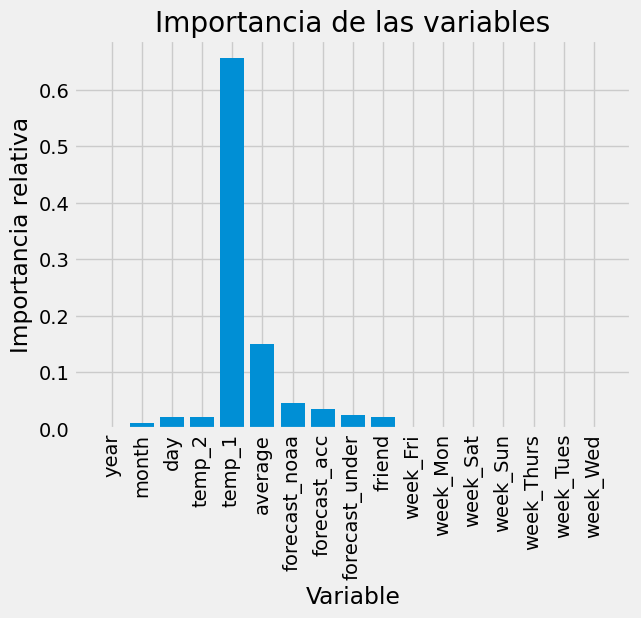

In [ ]:

# Importa matplotlib.pyplot con alias plt
import matplotlib.pyplot as plt

%matplotlib inline

# Elegimos el estilo de visualización
# Configura o dibuja elementos del gráfico
plt.style.use('fivethirtyeight')

# Línea de código del flujo principal
x_values = list(range(len(importances)))

# Creamos el diagrama de barras
# Configura o dibuja elementos del gráfico
plt.bar(x_values, importances, orientation = 'vertical')

# Ponemos las etiquetas del eje x
# Configura o dibuja elementos del gráfico
plt.xticks(x_values, feature_list, rotation='vertical')

# Axis labels and title
# Configura o dibuja elementos del gráfico
plt.ylabel('Importancia relativa'); plt.xlabel('Variable'); plt.title('Importancia de las variables');

In [ ]:
# Importa el paquete datetime
import datetime

# Fechas de los valores de train
months = features[:, feature_list.index('month')]
days = features[:, feature_list.index('day')]
years = features[:, feature_list.index('year')]

# Convertimos los valores de tiempo en objetos
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

# Creamos un dataframe con los valores y las fechas correspondientes
true_data = pd.DataFrame(data = {'date': dates, 'actual': labels})

# Hacemos la predicción temporal
months = test_features[:, feature_list.index('month')]
days = test_features[:, feature_list.index('day')]
years = test_features[:, feature_list.index('year')]

# Columna de fechas
test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]

# Convertimos los datetime objects
test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]

# Dataframe con predicciones y fechas
predictions_data = pd.DataFrame(data = {'date': test_dates, 'prediction': predictions})

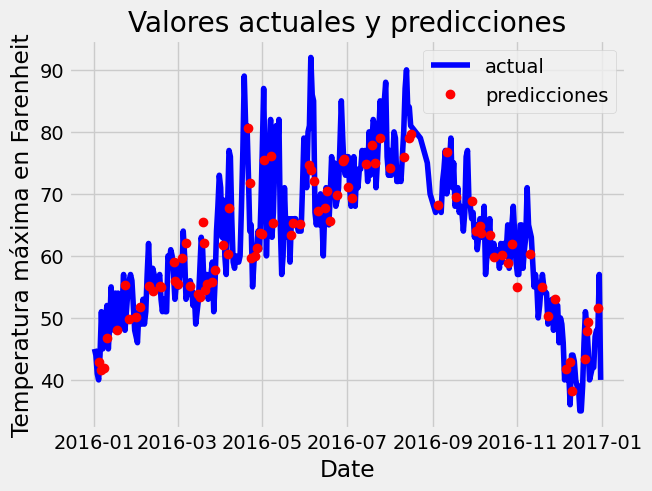

In [ ]:
# Graficamos los valores actuales
# Configura o dibuja elementos del gráfico
plt.plot(true_data['date'], true_data['actual'], 'b-', label = 'actual')

# Graficamos los valores predichos
# Configura o dibuja elementos del gráfico
plt.plot(predictions_data['date'], predictions_data['prediction'], 'ro', label = 'predicciones')
# Configura o dibuja elementos del gráfico
plt.xticks(rotation = 'horizontal');
# Configura o dibuja elementos del gráfico
plt.legend()

# Graph labels
# Configura o dibuja elementos del gráfico
plt.xlabel('Date'); plt.ylabel('Temperatura máxima en Farenheit'); plt.title('Valores actuales y predicciones');


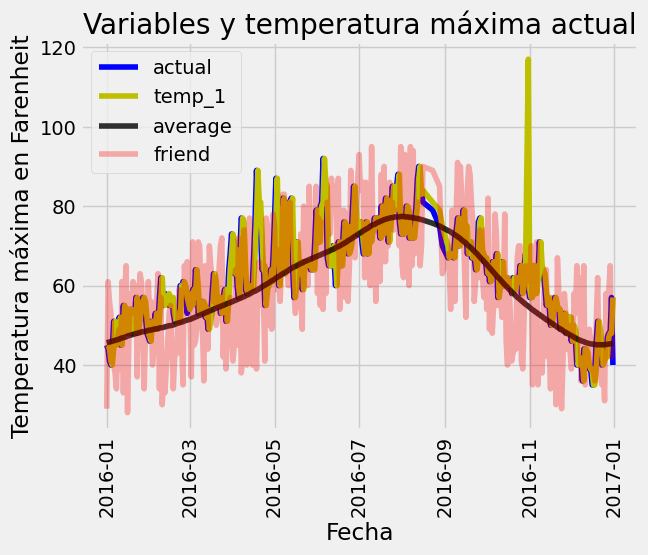

In [ ]:
# Creamos una estructura para que nos sea después más fácil acceder a los datos del gráfico
true_data['temp_1'] = features[:, feature_list.index('temp_1')]
true_data['average'] = features[:, feature_list.index('average')]
true_data['friend'] = features[:, feature_list.index('friend')]

# Graficamos todas las fechas como líneas
# Configura o dibuja elementos del gráfico
plt.plot(true_data['date'], true_data['actual'], 'b-', label  = 'actual', alpha = 1.0)
# Configura o dibuja elementos del gráfico
plt.plot(true_data['date'], true_data['temp_1'], 'y-', label  = 'temp_1', alpha = 1.0)
# Configura o dibuja elementos del gráfico
plt.plot(true_data['date'], true_data['average'], 'k-', label = 'average', alpha = 0.8)
# Configura o dibuja elementos del gráfico
plt.plot(true_data['date'], true_data['friend'], 'r-', label = 'friend', alpha = 0.3)

# Roto el gráfico para una mejor visualización
# Configura o dibuja elementos del gráfico
plt.legend(); plt.xticks(rotation = 'vertical');

# Añado título y ejes
# Configura o dibuja elementos del gráfico
plt.xlabel('Fecha'); plt.ylabel('Temperatura máxima en Farenheit'); plt.title('Variables y temperatura máxima actual');